<a href="https://colab.research.google.com/github/liangzhidanta/dl/blob/%E5%8E%9F%E5%A7%8B%E4%BD%9C%E4%B8%9A%E5%88%86%E6%94%AF/HW02/HW02-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.
## DARPA TIMIT声学语音连续语音语料库（TIMIT）
TIMIT阅读语音语料库旨在为获取声学语音知识以及开发和评估自动语音识别系统提供语音数据。

This homework is a multiclass classification task,
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [1]:

# 使用 gdown 工具从 Google Drive 下载文件
# 解压下载的 zip 文件
# 列出当前目录下的文件和文件夹
""" !gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!unzip data.zip
!ls """

" !gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip\n!unzip data.zip\n!ls "

## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [2]:

import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy') #np.load()函数用于加载npy文件，返回一个numpy数组，参数是文件名
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))  #format()函数用于格式化输出，参数是格式字符串和需要格式化的数据
print('Size of testing data: {}'.format(test.shape))    #shape属性返回一个元组，元组中的每个元素表示数组的维度

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


## Create Dataset

In [3]:
import torch
from torch.utils.data import Dataset #Dataset是一个类，用来定义数据集

class TIMITDataset(Dataset):    
    def __init__(self, X, y=None):    #如果y不为空，则将y转换为torch.LongTensor类型
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):     #__getitem__是一个方法，用来定义索引操作，输入为索引，输出为数据
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):              #__len__是一个方法，用来定义长度操作，输出为数据集的长度
        return len(self.data)


在展示训练函数的实现之前，我们[**定义一个在动画中绘制数据的实用程序类**]`Animator`，
它能够简化本书其余部分的代码。

In [4]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display
# 定义 use_svg_display 函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

# 定义 set_axes 函数
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置 Matplotlib 的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
 

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()   
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.clear_output(wait=True) # 不输出新图像，而是覆盖之前的图像
        display.display(self.fig)   # 输出图像
        

测试绘图代码

d:\miniconda3\envs\dl\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


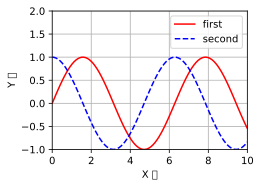

In [5]:
# 创建动漫实例
animator = Animator(xlabel='X 轴', ylabel='Y 轴', legend=['first', 'second'],
                    xlim=(0, 10), ylim=(-1, 2), xscale='linear', yscale='linear',
                    fmts=['r-', 'b--'])

# 生成数据
x = np.linspace(0, 10, 100)

# 逐点绘制两条曲线
for i in range(len(x)):
    # 曲线1: y1 = sin(x)
    y1 = np.sin(x[i])
    # 曲线2: y2 = cos(x)
    y2 = np.cos(x[i])
    animator.add(x[i], [y1, y2])
    display.clear_output(wait=True)  # 清除之前的输出

Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [6]:
VAL_RATIO = 0.2       # 决定训练集和验证集的比例

percent = int(train.shape[0] * (1 - VAL_RATIO))     # train.shape[0]该数组的行数
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:] # :present表示输出所有行，[present:]表示输出从present行开始到末尾的所有行
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (983945, 429)
Size of validation set: (245987, 429)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [7]:
BATCH_SIZE = 512

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [8]:
import gc   #gc是一个内置库，用于管理内存

del train, train_label, train_x, train_y, val_x, val_y  #del是删除变量的语句
gc.collect()    # 释放内存，输出的数字是释放了多少内存，单位为字节

7584

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [9]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):     
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(429, 1024)  # 429 is the number of features
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, 39)
        #修改计划函数为relu
        self.act_fn = nn.ReLU()
        #self.act_fn = nn.Sigmoid()

    def forward(self, x):   
        x = self.layer1(x)
        x = self.act_fn(x)

        x = self.layer2(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        x = self.act_fn(x)

        x = self.out(x)

        return x

## Training

In [10]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

In [11]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [12]:
# fix random seed for reproducibility
same_seeds(0)

# get device
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 20               # number of training epoch
learning_rate = 0.0001       # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


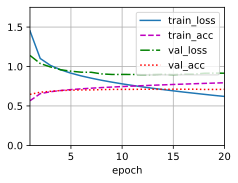

[020/020] Train Acc: 0.794297 Loss: 0.620886 | Val Acc: 0.710700 loss: 0.915206


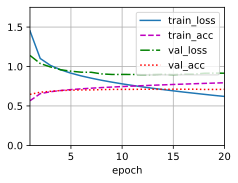

In [13]:
# start training
# 初始化画图
animator = Animator(xlabel='epoch', xlim=[1, num_epoch], ylim=[0., 1.75],
                            legend=['train_loss', 'train_acc','val_loss', 'val_acc'])

best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()
        
    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1)

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()
            # 绘图
            animator.add(epoch + 1, [train_loss / len(train_loader), train_acc / len(train_set),val_loss / len(val_loader), val_acc / len(val_set)])
        
            # if the model improves, save a checkpoint at this epoch    
            # 打印    
            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))
        # 绘制训练损失和准确率
    
# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [14]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

D:\系统缓存\ipykernel_19940\2373171232.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Make prediction.

In [15]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [16]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))